# "It's only wafer-thin" -- Preventing state explosion with observers

Following the discussion [here](https://community.cadcad.org/t/mitigating-cadcad-overhead/140/8), we present an alternate version of the [Beacon Runner simulation](beacon_runner_2049.ipynb) where the cadCAD state is not deep-copied and retained at each step. This makes the simulation significantly faster, but means that we cannot rely on our previous process where "statistics" (e.g., what we called `active_stake_branch_0`) are obtained from the historical record contained in `df`.

Instead, we define functions of the state ("observers") which are seamlessly included as state variables. We use a [fork of cadCAD](https://community.cadcad.org/t/mitigating-cadcad-overhead/140/5?u=barnabemonnot) where the state is shallow-copied at each step and make sure our observers return shallow values. For instance, we don't necessarily want to record the state of the `Network` and the two `BeaconState` objects, but we do want to see the evolution of the stake for both groups of validators in both partitions. The measured value is returned by a simple function of the current state, and can be recorded shallowly.

In [1]:
import specs
import importlib
from eth2spec.config.config_util import prepare_config

prepare_config(".", "medium")
importlib.reload(specs)

import network as nt
import brlib

import copy

from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd

from cadCADsupSUP import (
    get_observed_initial_conditions, get_observed_psubs,
    add_loop_ic, add_loop_psubs
)

genesis_state = brlib.get_genesis_state(1000)
brlib.process_genesis_block(genesis_state)
specs.process_slots(genesis_state, 1)
genesis_state_2 = copy.deepcopy(genesis_state)

set_a = nt.NetworkSet(validators=list(range(0,600)), beacon_state=genesis_state)
set_b = nt.NetworkSet(validators=list(range(600,1000)), beacon_state=genesis_state_2)
network = nt.Network(sets=list([set_a, set_b]))

initial_conditions = {
    'network': network
}

def active0(state):
    return sum(
        [state["network"].sets[0].beacon_state.validators[validator_index].effective_balance
         for validator_index in state["network"].sets[0].validators]
    ) / len(state["network"].sets[0].validators)

def inactive0(state):
    return sum(
        [state["network"].sets[0].beacon_state.validators[validator_index].effective_balance
         for validator_index in state["network"].sets[1].validators]
    ) / len(state["network"].sets[1].validators)

def active1(state):
    return sum(
        [state["network"].sets[1].beacon_state.validators[validator_index].effective_balance
         for validator_index in state["network"].sets[1].validators]
    ) / len(state["network"].sets[1].validators)

def inactive1(state):
    return sum(
        [state["network"].sets[1].beacon_state.validators[validator_index].effective_balance
         for validator_index in state["network"].sets[0].validators]
    ) / len(state["network"].sets[0].validators)

# We add the dictionary of observers
observers = {
    "active_stake_branch_0": active0,
    "inactive_stake_branch_0": inactive0,
    "active_stake_branch_1": active1,
    "inactive_stake_branch_1": inactive1
}

# Write out our PSUBs as before
psubs = [
    # Step 1+2
    {
        'policies': {
            'action': brlib.attest_policy
        },
        'variables': {
            'network': brlib.disseminate_attestations
        }
    },
    # Step 3+4
    {
        'policies': {
            'action': brlib.propose_policy
        },
        'variables': {
            'network': brlib.disseminate_blocks
        }
    }
]

initial_conditions = add_loop_ic(initial_conditions)
psubs = add_loop_psubs(psubs)

# We transform initial conditions and PSUBs to include initial observed values
# and include observed values as state variables
obs_ic = get_observed_initial_conditions(initial_conditions, observers)
obs_psubs = get_observed_psubs(psubs, observers)

In [2]:
%%capture

simulation_parameters = {
    'T': range(300),
    'N': 1,
    'M': {}
}

config = Configuration(initial_state=obs_ic,
                       partial_state_update_blocks=obs_psubs,
                       sim_config=simulation_parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config])
raw_result, tensor = executor.execute()
df = pd.DataFrame(raw_result)

We can now get functions of our observers.

In [3]:
# Activity ratio of validators in the first partition
df['activity_ratio_0'] = df['active_stake_branch_0'] * 60 / df['inactive_stake_branch_0'] / 40

# Activity ratio of validators in the second partition
df['activity_ratio_1'] = df['active_stake_branch_1'] * 40 / df['inactive_stake_branch_1'] / 60

All entries of the `"network"` column in `df` refer to the same object, which is the last update to the `Network` state variable. So we can just drop that column.

In [4]:
df = df.drop(columns = ["network"])

In [5]:
df

,loop_time,active_stake_branch_0,inactive_stake_branch_0,active_stake_branch_1,inactive_stake_branch_1,run,substep,timestep,activity_ratio_0,activity_ratio_1
0,1.588574e+09,3.200000e+10,3.200000e+10,3.200000e+10,3.200000e+10,1,0,0,1.500000,0.666667
1,1.588574e+09,3.200000e+10,3.200000e+10,3.200000e+10,3.200000e+10,1,1,1,1.500000,0.666667
2,1.588574e+09,3.200000e+10,3.200000e+10,3.200000e+10,3.200000e+10,1,2,1,1.500000,0.666667
3,1.588574e+09,3.200000e+10,3.200000e+10,3.200000e+10,3.200000e+10,1,1,2,1.500000,0.666667
4,1.588574e+09,3.200000e+10,3.200000e+10,3.200000e+10,3.200000e+10,1,2,2,1.500000,0.666667
...,...,...,...,...,...,...,...,...,...,...
596,1.588575e+09,3.200000e+10,1.700000e+10,3.200000e+10,6.000000e+09,1,2,298,2.823529,3.555556
597,1.588575e+09,3.200000e+10,1.700000e+10,3.200000e+10,6.000000e+09,1,1,299,2.823529,3.555556
598,1.588575e+09,3.200000e+10,1.700000e+10,3.200000e+10,6.000000e+09,1,2,299,2.823529,3.555556
599,1.588575e+09,3.200000e+10,1.700000e+10,3.200000e+10,6.000000e+09,1,1,300,2.823529,3.555556


In [6]:
%matplotlib inline

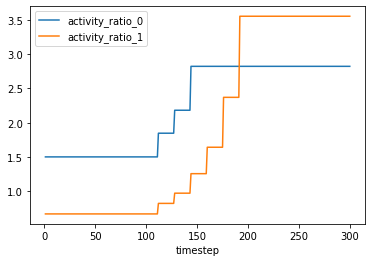

In [7]:
df[df.substep == 1].plot('timestep', ['activity_ratio_0', 'activity_ratio_1'])